<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer

-Work in progress (last updated:28/03/2023)-

A. MOTIVATION

ИК-спектроскопия является универсальным и точным методом химической идентификации, поскольку каждое соединение обладает уникальными ИК-спектральными характеристиками; однако спектральные характеристики, как правило, неоднозначны. Интерпретация вручную часто отнимает много времени и может привести к непоследовательным, ошибочным результатам. Следовательно, существует потребность в быстрой, точной и воспроизводимой альтернативе ручному переводу.

B. Цель

Целью этой программы является автоматизация процедуры интерпретации ИК-спектра известного соединения путем присвоения его полос поглощения имеющимся в молекуле химическим связям или типам колебаний.

C. План

Для реализации задумки предлагается решить следующие задачи:

1. Исходя из списка веществ NIST получить таблицу, содержащую данные про соединения (CAS, название, брутто-формула, молекулярная масса, элементы в составе, SMILE, SELFIE, InChi обозначения, список имеющихся в структуре связей и функциональных групп.
2. Получить ИК-спектры из списка химических веществ, по CAS ключу.
3. Построить соответствие между спектрами и labels, разобраться с типами и количестом labels, осуществить подбор правильного embending для кодирования label.
4. Обработать спектры, приведя их к единому виду и форме. Провести интерполяцию для получения спектров с единым шагом и желательно в едином диапазоне волновых чисел.
5. Визуализировать статистику по выборке, оценить баланс классов.
6. Создать объект torch.DataSet, разбить выборку на test, train, val с учётом дисбаланса.
7. Далее работу перевести в другой блокнот для создания и обучения модели.

NOTES
1. Получен список веществ, создана таблица.
2. Скачаны спектры более 14000 соединений. 
3. Разработаны функции для сбора данных label на основе таблицы и существующих спектров.
4. Визуализированы списки классов.
5. Форматируются спектры по одному интервалу.
6. Добавлена функция поиска пиков.

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [ ]:
!git clone https://github.com/Lamblador/IR_expert_system.git

fatal: destination path 'IR_expert_system' already exists and is not an empty directory.


In [ ]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install cirpy
!pip install peakutils
!pip install datamol
!pip install rdkit
clear_output()

In [ ]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
import re  # for string manipulations
import requests
#import peakutils
from bs4 import BeautifulSoup  # for webscraping
import urllib.request
import time
import random
from tqdm import tqdm
import jcamp
from jcamp import jcamp_readfile
import glob
import os
import numpy as np
from urllib.request import urlopen
import logging
import argparse
import sys
import datamol as dm
import scipy
from scipy import interpolate

from rdkit import Chem, RDLogger

# Obj. 1 Получение таблицы данных: Task 1. Сохранение периодической таблицы химических элементов:

In [ ]:
#create an ordered dictionary. In this case, order of elements is important.
import collections

# periodic_table['element_name']=['atomic_number','atomic_mass']
periodic_table = collections.OrderedDict()  # initialize dictionary.


def create_periodic_table(file_name):
    """ Read a text file line-by-line and extract information for: atomic number, atomic symbol, and relative atomic mass 

        The author is aware of at least one python periodic elements package (e.g., https://pypi.python.org/pypi/periodictable),
        but chose to implement a different approach.
    """

    file = open(file_name, 'r')  # open a file to read

    for line in file:  # read file line-by-line, extract values, and store into a dictionary

        if line.startswith('Atomic Number'):
            line = line.replace(" ", "")
            value1 = line.split('=', 1)

        if line.startswith('Atomic Symbol'):
            line = line.replace(" ", "")
            key = line.split('=', 1)

        if line.startswith('Relative Atomic Mass'):
            line = line.replace(" ", "")
            value2 = line.split('=', 1)

            # Store values into dictionary only if the element is unique.
            # Otherwise, the atomic mass will be override by isotope's atomic
            # mass.
            if key[1].strip() not in list(periodic_table.keys()):
                periodic_table[key[1].strip()] = [
                    value1[1].strip(), value2[1].strip()]
            else:
                pass

    return periodic_table

# End of functions

In [ ]:
# 1-1a. Call out function
file_name = '/content/IR_expert_system/data/NIST_periodic_table.txt'
periodic_table = create_periodic_table(file_name)

# 1-1b.Test out dictionary by calling out the element keys
print(list(periodic_table.keys()))
print("\n")
print("Number of dictinct elements in the dictionary:", len(periodic_table))

['H', 'D', 'T', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


Number of dictinct elements in the dictionary: 120


## Obj. 1 Task2: Получение таблицы из списка соеинений NIST и расчёт молярной массы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re  # for string manipulations
import requests
#import peakutils
from bs4 import BeautifulSoup  # for webscraping
#from peakutils.peak import indexes as index_utils  # for peak picking


def read_and_clean_nist_chem_list(no_of_files=72619):
    """ Read and clean a stored csv file called "NIST_chemicals_list.csv" 

    Args:
    no_of_files=specifies how many files to read from the list. The max. no. is 72619.

    Returns:
    a NIST chemicals list dataframe.

    """

    # read file
    col_names = ['Name', 'Formula', 'CAS']
    # Rename columns
    df = pd.read_csv("/content/IR_expert_system/data/NIST_chemicals_list.csv", header=1, names=col_names)
    # Remove rows that have null objects and keep only rows with no na values
    df = df.dropna()
    # make CAS the index column
    df = df.set_index('CAS')

    return df

    
def extract_unique_elements(df):
    """Given a pandas DataFrame containing a column of chemical formula, return the DataFrame 
        with an additional column containing unique elements in the formula called df['Elements']
    
        Args:
        df_Formula=a column of chemical formula in a pandas DataFrame
        Return:
        a list of unique elements
    """

    #1a. check for formulas that contain ')n' and remove it
    ##df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')   
    df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','') 
    #1b. check for formulas that contain '.xW' and remove it
    df.loc[df['Formula'].str.contains('xW')==True,'Formula']=df[df['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1c. check for formulas that contain '.XH2O' and remove it
    df.loc[df['Formula'].str.contains('XH2O')==True,'Formula']=df[df['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1d. check for formulas that contain 'xC6' and remove it
    df.loc[df['Formula'].str.contains('xC6')==True,'Formula']=df[df['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    #2. apply regex to extract unique elements in chemical formula
    df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers
    #3. df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    return df


def filter_by_elements(df, elements_list):
    """ Filter compounds to contain any, but not exceeding the elements on the specified list: elements_list s

    Args:
    df=specify a dataframe on which we want to perform filtering by elements.
    elements_list=provide a list of elements in which the desired compounds contain, e.g., ['C', 'O', 'H']

    Returns:
    returns compounds that contain the listed elements.

    """

    # Create a blank pandas DataFrame
    new_df = pd.DataFrame()

    for i, element in enumerate(df.Formula):
        # strip chemical formula and leave out only the alphabets
        s_proc = re.sub('[^a-zA-Z]+', '', element)
        for allowed_element in elements_list:
            # subtract stripped formula with elements list
            s_proc = s_proc.replace(allowed_element, "")
            #print("s_proc:", s_proc)
            # If the stripped formula is completely anihilated, then all elements must have matched
            # Thus, append compound to the new DataFrame
            if (s_proc == ""):
                #    print("s_proc:", s_proc)
                new_df = new_df.append(df.iloc[i, :])
            # s_proc=re.findall('\D+', each) #extract only letters

    # relabel index column
    new_df.index.name = "CAS"
    return new_df  # returns a list


def calc_molec_weight(nist_chem_list, periodic_table):
    """ Calculate molecular weight, Mw, given a chemical formula, df.Formula 
    #ref.: https://stackoverflow.com/questions/41818916/calculate-molecular-weight-based-on-chemical-formula-using-python

    Args:
    nist_chem_list=a pandas DataFrame from which Mw will be calculated.
    periodic_table=a periodic table dictionary from which the atomic weight of each element can be retrieved.

    Returns:
    the same dataframe, but with an extra column added. This extra column is labelled as 'Mw'.

    """

    #1a. check for formulas that contain '.xW' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xW'),'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1b. check for formulas that contain '.XH2O' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('XH2O')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1c. check for formulas that contain 'xC6' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xC6')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    for i, each in enumerate(nist_chem_list.Formula):

        # separate atomic symbols from atomic ratios
        total_weight = 0  # initialize total weight
        s = re.findall('([A-Z][a-z]?)([0-9]*)', each)

        for elem, count in s:
            if count == '':  # For singular elements
                count = 1
            else:
                pass
            try:
                total_weight += int(count) * \
                    float(re.sub('[(#)]', '', periodic_table[elem][1]))
            except: 
                print("error:", nist_chem_list.iloc[i,1])
                continue

        # Append total weight to a new column in pandas DataFrame
        nist_chem_list.loc[nist_chem_list.index[i], 'Mw'] = total_weight
    return nist_chem_list
    

def create_func_group_table():
    """ Scrape a table from wikipedia and load it into a pandas DataFrame 

    Args:
    None

    Returns:
    df=a pandas DataFrame of functional group classification.

    """

    # Request information from wikipedia
    res = requests.get(
        "https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups")

    # Create a BeautifulSoup class
    soup = BeautifulSoup(res.content, 'lxml')

    # Extract info. from a table
    table = soup.find_all(class_="wikitable")[0]

    # Load table info. into a Pandas DataFrame
    df = pd.read_html(str(table), header=0)[0] #, index_col='Chemical class')[0]
    
    return df


# def pick_peaks(title_name, x, y):
#     """ Given x and y values, pick peaks using PeakUtils python package by identifying peak maxima and plot graphs. 
#         This algorithm is a 1-D search. In the calculation, it doesn't account for the x-values.

#         ref.: https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work

#     parameters:
#     The sensitivity of the peak picking algorithm can be varied by changing the thres and min-dist 
#     in the index_utils object (see below).

#     Args:
#     title_name=specify the title of the data, which will be displayed on the final plot. 
#     x=specfy x values.
#     y=specfy y values.

#     Returns:
#     plots spectra with marked peaks.

#     """

#     # print('Detect peaks with minimum height and distance filters.')
#     index_utils = index_utils(np.array(y), thres=0.02 / max(y), min_dist=5)
#     # print('Peaks are: %s' % (indexes))

#     x_max = []
#     y_max = []

#     for each in index_utils:
#         x_max.append(x[each])
#         y_max.append(y[each])

#     # plot the x,y pair of the identified maxima data points, i.e., indexes,
#     # max_peaks:
#     plt.plot(x, y)
#     plt.plot(x_max, y_max, 'rD', alpha=0.3)

#     plt.title(title_name)
#     plt.ylabel("Absorbance")  # All units are transformed to absorbance
#     plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm

# # End of functions

In [ ]:
# 1-2a. Generate nist chemicals list by calling out the read_and_clean_nist_chem_list function 
nist_chem_list = read_and_clean_nist_chem_list()
# print(df.head()) #check

# 1-2b. Calculate molecular weight of compounds and append to
# nist_chem_list: nist_chem_list_app1
##nist_chem_list_app1 = calc_molec_weight(filtered_nist_chem_list, periodic_table)
nist_chem_list_Mw = calc_molec_weight(nist_chem_list, periodic_table)
#print(nist_chem_list_Mw.head(5)) #check

#1-2c
#Extract unique elements and append a new column called 'Elements'
nist_chem_list_Mw_el=extract_unique_elements(nist_chem_list_Mw)
print(nist_chem_list_Mw_el.head(5)) #check


<ipython-input-6-592addf35fbd>:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')
<ipython-input-6-592addf35fbd>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers


                                                        Name     Formula  \
CAS                                                                        
100-00-5                          Benzene, 1-chloro-4-nitro-   C6H4ClNO2   
100-01-6                                      p-Nitroaniline    C6H6N2O2   
100-02-7                                    Phenol, 4-nitro-     C6H5NO3   
100043-29-6                                     2H-Tetrazole       CH2N4   
100046-00-2  2,2,4,4',6,6'-Hexamethylazobenzene N,N'-dioxide  C18H22N2O2   

                     Mw          Elements  
CAS                                        
100-00-5     156.993056  [C, H, Cl, N, O]  
100-01-6     138.042927      [C, H, N, O]  
100-02-7     139.026943      [C, H, N, O]  
100043-29-6   70.027946         [C, H, N]  
100046-00-2  298.168128      [C, H, N, O]  


In [ ]:
#WORK IN PROGRESS

# 1-2d. Create a functional group table DataFrame
func_group_table = create_func_group_table()
#print(func_group_table.head())

#strip off '-'
func_group_table.loc[func_group_table['Suffix'].str.contains('-')==True,'Suffix']=func_group_table[func_group_table['Suffix'].str.contains('-')==True]['Suffix'].str.replace('-','')
func_group_table.loc[func_group_table['Prefix'].str.contains('-')==True,'Prefix']=func_group_table[func_group_table['Prefix'].str.contains('-')==True]['Prefix'].str.replace('-','')
print(func_group_table)

#Create a new column with functional group assignment
#WORK IN PROGRESS

"""
for i,j in enumerate(nist_chem_list_Mw_el.Name):
    #print(nist_chem_list_Mw_el.Name.str.contains(j))
    print(nist_chem_list_Mw_el.Name.str.contains(j))
        #print("Yes")
        #print(nist_chem_list_Mw_el.Name.iloc[i])
"""


    Sr No.                        Chemical class               Group  \
0        1                           Acyl halide          Haloformyl   
1        2                               Alcohol            Hydroxyl   
2        3                              Aldehyde            Aldehyde   
3        4                                Alkane               Alkyl   
4        5                                Alkene             Alkenyl   
5        6                                Alkyne             Alkynyl   
6        7                                 Amide         Carboxamide   
7        8                                Amines       Primary amine   
8        8                                Amines     Secondary amine   
9        8                                Amines      Tertiary amine   
10       8                                Amines     4° ammonium ion   
11       9                          Azo compound        Azo(Diimide)   
12      10                    Toluene derivative              Be

'\nfor i,j in enumerate(nist_chem_list_Mw_el.Name):\n    #print(nist_chem_list_Mw_el.Name.str.contains(j))\n    print(nist_chem_list_Mw_el.Name.str.contains(j))\n        #print("Yes")\n        #print(nist_chem_list_Mw_el.Name.iloc[i])\n'

### Группировка соединений в группы по типам

In [ ]:
#Check for chemicals that contains certain elements
#I. Generate elements list

#A. organic compounds
organic=['C','H','O','N','S','P','B','Cl', 'F', 'I', 'Br'] 

#B. Transition metals
t_metals=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(22,32):
        t_metals.append(j)
    elif i in range(40,50):
        t_metals.append(j)
    elif i in range(73,82):
        t_metals.append(j)

print(t_metals)

#C. lanthanides and actinides list is no 57-71 and 89-103
f_block=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(58,73):
        f_block.append(j)
    elif i in range(90,105):
        f_block.append(j)
print('\n')
print(f_block)

##############################
##############################
#II. group elements based on the elements list

#A. organic compounds
nist_chem_list_organic=[]
nist_chem_list.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list.csv") #Saving csv file
#Return chemicals with at least one matching elements in the list
[nist_chem_list_organic.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(organic))==0] #Check for matching elements

nist_chem_list_organic=pd.DataFrame(nist_chem_list_organic) #convert list into a dataframe

nist_chem_list_organic = nist_chem_list_organic.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
#print(nist_chem_list_organic.head())
nist_chem_list_organic.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_organic.csv")  #Saving csv file
##nist_chem_list_organic.info()

#print("No. of organic compounds:", len(nist_chem_list_organic.Name))

#print(nist_chem_list[set(nist_chem_list.Elements).intersection(list1)])

#[print(nist_chem_list.Elements) if e in nist_chem_list.Elements]
#set(nist_chem_list.Elements).intersection(list1)
#nist_chem_list.columns

#B. Transition metals
nist_chem_list_t_metals=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_t_metals.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(t_metals))==0] #Check for matching elements

nist_chem_list_t_metals=pd.DataFrame(nist_chem_list_t_metals) #convert list to pandas dataframe
nist_chem_list_t_metals = nist_chem_list_t_metals.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_t_metals.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_t_metals.csv")  #Saving csv file
#print("No. of transition metals:", len(nist_chem_list_t_metals))

##nist_chem_list_t_metals.info()
#print(nist_chem_list_t_metals)

#C. lanthanides

nist_chem_list_f_block=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_f_block.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(f_block))==0] #Check for matching elements

nist_chem_list_f_block=pd.DataFrame(nist_chem_list_f_block) #convert list to pandas dataframe
nist_chem_list_f_block = nist_chem_list_f_block.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_f_block.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_f_block.csv")  #Saving csv file
#print("No. of f-blocks:", len(nist_chem_list_f_block))
#print('\n')
##nist_chem_list_lanthanides.info()
#print(nist_chem_list_lanthanides)



['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg']


['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']


## [✓] Obj. 1 Task 2 is partially completed.

The following tools have been implemented:

-For determining the unique elements present in the NIST chemicals list. 
-For filtering compounds that contain specific set of elements
-For calculating molecular weight of compounds

*Two more features that need to be implemented are:
    a. Classifying the compounds into various families of function groups: 
    ref.: https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups
    -> The function for web scraping has been created. The next step is to implement this function on the compounds.
    b. Identify peaks in each of the spectra and add a new column that lists the picked peaks.

## Obj. 1 Task 3: Сортировка таблицы (опционально)

I. Содержание различных групп химических соединений.

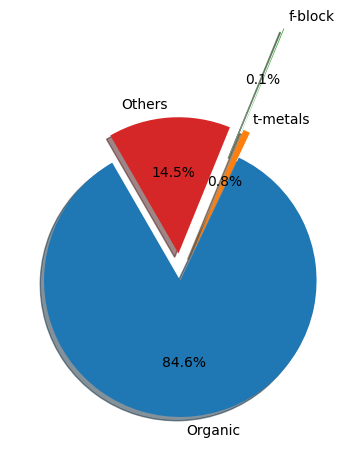

Compounds breakdown:


 Organic: 37611

 t-metals: 361

 f-block: 40

 Others: 6443

 Total: 44455


In [ ]:
#draw pie chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Organic', 't-metals', 'f-block', 'Others' 
others=len(nist_chem_list)-sum([len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block)])
sizes = [len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block), others]
explode = (0, 0.2, 1.0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=120, autopct='%1.1f%%')
#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

print("Compounds breakdown:\n")
print("\n Organic:", len(nist_chem_list_organic))
print("\n t-metals:", len(nist_chem_list_t_metals))
print("\n f-block:", len(nist_chem_list_f_block))
print("\n Others:", others)
print("\n Total:", len(nist_chem_list))


II. Распеределение молекулярных масс

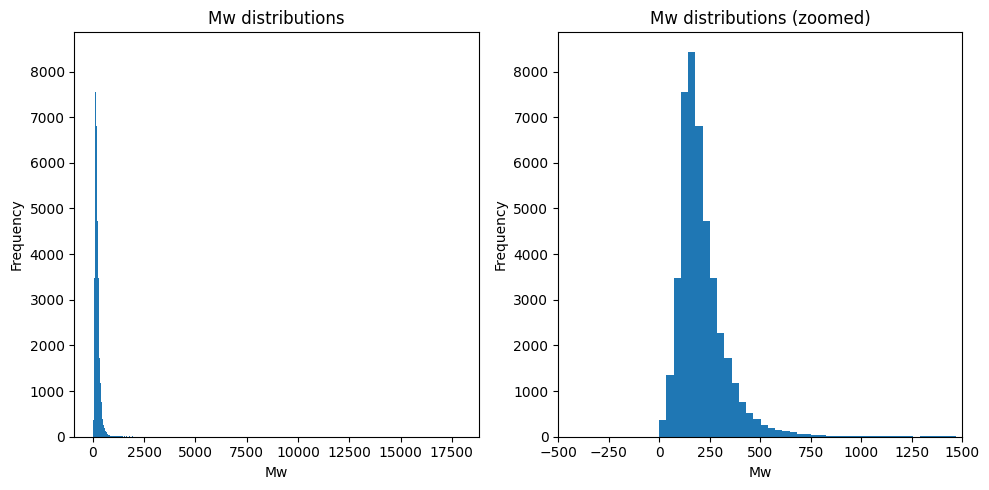

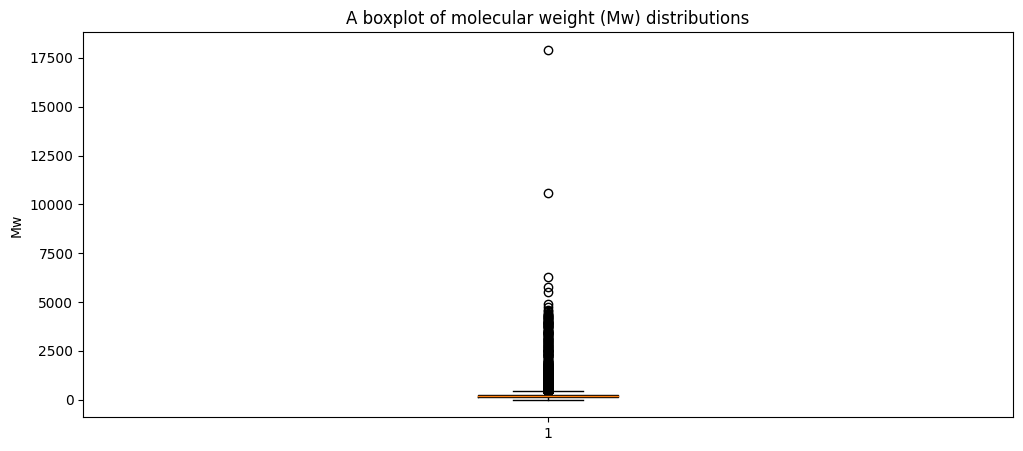



Some statistics count    44455.000000
mean       221.754239
std        231.506335
min          0.000000
25%        136.125201
50%        184.052429
75%        256.096026
max      17912.691751
Name: Mw, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 44455 entries, 100-00-5 to 999-97-3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      44455 non-null  object 
 1   Formula   44455 non-null  object 
 2   Mw        44455 non-null  float64
 3   Elements  44455 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.7+ MB
Data overview None


In [ ]:
# A. Generate a histogram of molecular weight distribution
# plt.figure(figsize=(20,10))

##nist_chem_list_app1.Mw.plot(kind='hist', bins=100, normed=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.title('Mw distributions')

plt.subplot(1,2,2)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.xlim(-500,1500)
plt.title('Mw distributions (zoomed)')
plt.tight_layout()

# B. show a box plot of Mw distributions
plt.figure(figsize=(12,5))

# nist_chem_list_app1.Mw.plot(kind='box')
plt.boxplot(nist_chem_list_Mw_el.Mw)

plt.title('A boxplot of molecular weight (Mw) distributions')
plt.ylabel('Mw')

plt.show()

print("\n")
print("Some statistics", nist_chem_list_Mw_el.Mw.describe())
print("\n")
print("Data overview", nist_chem_list_Mw_el.info())


In [ ]:
#check which compounds are in the outliers
#A. Mw=0
mw_eq_0=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw==0]
print("No of elements with Mw=0:", len(mw_eq_0))

#check original entries
##cas_list=['25988-63-0', '26700-39-0', '26982-20-7', '61257-62-3', '61857-39-4']
#nist_chem_list.index.name

#print(nist_chem_list.head())   
##df=pd.read_csv("data/NIST_chemicals_list.csv")    
##df.columns=['Name','Formula','CAS']
##df.head(3)

#nist_chem_list.loc['26700-39-0']
##for i in cas_list:
##    print(df[df['CAS']==i])

#B. Mw>1000
mw_gt_1000=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw>1000]
print("No of elements with Mw>1000:",len(mw_gt_1000))
#print(mw_gt_1000)
#print(mw_gt_1000.index)
#print(len(mw_gt_1000))    

#C. Check for duplicates
print("Number of chemicals in the list:", len(nist_chem_list_Mw_el.iloc[:,0]))
print("Number of chemicals with unique CAS number in the list:", len(set(nist_chem_list_Mw_el.index))) 
#There are no duplicates. Good!



No of elements with Mw=0: 5
No of elements with Mw>1000: 271
Number of chemicals in the list: 44455
Number of chemicals with unique CAS number in the list: 44455


# Obj. 2 Скачивание спектров, полученных парсингом сайта NIST

In [ ]:
import urllib.request
import requests
import pandas as pd
import time
import random
from tqdm import tqdm
def download_jcamp_from_nist(cas_list, minimum_file_size=1000, start_of_files = 0, no_of_files=20):
    """ Download jcamp files from NIST website by calling out CAS values (i.e., the df index) from chemicals DataFrame, df

    Args:
    cas_list=a list consisting of CAS no.
    size=the minimum file size at which the file will be downloaded.
    no_of_files=the number of files to download.

    Returns:
    automatically saves files into the same directory as this python program.
    print the name of the downloaded files.
    name of downloaded files

    """

    # NOTE THAT SOME OF THESE FILES TURN out to be empty.
    # Need to check file size before proceeding. Don't download if empty.
    # Files are saved in the same folder as this python script.

    # Download data based on CAS number partially

    for cas_no in cas_list[start_of_files:start_of_files+no_of_files]:
        # specify CAS no. separately
        cas_num = int(cas_no.replace("-", ""))
        url = "http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C%s&Index=1&Type=IR" % (
            cas_num) #Changed index from 0 to 1

        try:

            # Download only if size is significant. 1000 seems optimum.
            if len(requests.get(url).content) >= 1000:
                # Strip comma, apostrophe, and space in the file name because
                # it will mess up the ability of the jcamp program to read the
                # file.
                url_ret = urllib.request.urlretrieve(url, "/content/IR_expert_system/downloaded_jcamp/%s" % (cas_no))  # save file according to its cas_no
                # save by cas no.
                # url_ret = urllib.request.urlretrieve(url, "reference/%s" %(cas_no))  # save file according to its cas_no

                print(url_ret)  # print list of downloaded compounds

                # return url_ret
        except:
            continue


# End of functions

## Obj2. Task 1: Скачивание спектров с сайта.

In [ ]:
# DOWLOADED on the PC (will be uploaded later) 
#Need to complicate the approach by filtering the types of compounds
# Call out function to download. Place downloaded files into the "downloaded_jcamp" folder.
# nist_chem_list_organic=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_organic.csv')
# cas_all_list = []
# for i in range(len(nist_chem_list_organic['CAS'])):
#     cas_all_list.append(nist_chem_list_organic['CAS'][i])

In [ ]:
#Need to complicate the approach by filtering the types of compounds
# Call out function to download. Place downloaded files into the "downloaded_jcamp" folder.
nist_chem_list_f_block=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_f_block.csv')
cas_all_list = []
for i in range(len(nist_chem_list_f_block['CAS'])):
    cas_all_list.append(nist_chem_list_f_block['CAS'][i])
nist_chem_list_t_metals=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_t_metals.csv')
for i in range(len(nist_chem_list_t_metals['CAS'])):
    cas_all_list.append(nist_chem_list_t_metals['CAS'][i])

In [ ]:
# !mkdir /content/IR_expert_system/downloaded_jcamp/

In [ ]:
# batch = 20
# dowloaded = 0
# pause = random.random()/100

# for i in tqdm(range(0, len(cas_all_list)-batch ,batch)):

#     download_jcamp_from_nist(cas_all_list, 1000,start_of_files = i, no_of_files=batch)

#     dowloaded = dowloaded+1
#     time.sleep(pause)
# print(f"Parcing in finished. {dowloaded} steps of {batch} batches succesfully done!")
# # print(nist_chem_list_organic)

On the colab it does not work properly. So I made it of the my PC and upload all spectra into the git.hub

Updating the nist_chem_list with information about existance of the IR spectra.

In [ ]:
import os
cas_with_ir = []
cas_with_ir_filepass = []
for dirpath, _, filenames in os.walk('/content/IR_expert_system/downloaded_jcamp/ir'):
  for filename in filenames:
     cas_with_ir.append(filename)
     cas_with_ir_filepass.append(os.path.join(dirpath, filename))
#print(cas_with_ir_filepass)
#print(cas_with_ir)
ir_spectra_dic = {}
ir_spectra_dic["CAS"] = cas_with_ir
ir_spectra_dic["Pass_to_file"] = cas_with_ir_filepass
# Create DataFrame
nist_ir_spectra_df = pd.DataFrame(ir_spectra_dic)
nist_ir_spectra_df

,CAS,Pass_to_file
0,615-54-3,/content/IR_expert_system/downloaded_jcamp/ir/...
1,930-99-4,/content/IR_expert_system/downloaded_jcamp/ir/...
2,33901-44-9,/content/IR_expert_system/downloaded_jcamp/ir/...
3,3397-62-4,/content/IR_expert_system/downloaded_jcamp/ir/...
4,74-85-1,/content/IR_expert_system/downloaded_jcamp/ir/...
...,...,...
14829,6340-79-0,/content/IR_expert_system/downloaded_jcamp/ir/...
14830,103-60-6,/content/IR_expert_system/downloaded_jcamp/ir/...
14831,10364-94-0,/content/IR_expert_system/downloaded_jcamp/ir/...
14832,629-17-4,/content/IR_expert_system/downloaded_jcamp/ir/...


In [ ]:
nist_chem_list= nist_chem_list.reset_index()

In [ ]:
nist_ir_spectra_list = nist_chem_list.loc[nist_chem_list['CAS'].isin(cas_with_ir)]
nist_ir_spectra_list

,CAS,Name,Formula,Mw,Elements
0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]"
1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]"
2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]"
5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]"
6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]"
...,...,...,...,...,...
44447,99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]"
44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]"
44449,99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]"
44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"[C, H, N, O]"


In [ ]:
nist_ir_spectra_list.set_index('CAS').join(nist_ir_spectra_df.set_index('CAS'))

,Name,Formula,Mw,Elements,Pass_to_file
CAS,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
...,...,...,...,...,...
99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]",/content/IR_expert_system/downloaded_jcamp/ir/...
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]",/content/IR_expert_system/downloaded_jcamp/ir/...
99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]",/content/IR_expert_system/downloaded_jcamp/ir/...


# Obj3. Соотнесение спектров и классов.


##Task 1: Формирование списка скачанных спектров. 

In [ ]:
from IPython.core.display import clear_output
!pip install --upgrade jcamp
clear_output()

In [ ]:
# Plot one spectra that are located in the "downloaded_jcamp" folder
# Use jcamp codes to read jcamp files using jcamp package (taken from:
# https://pypi.python.org/pypi/jcamp/1.2.1).

import jcamp
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Create an empty list to store spectra data
ref_spectra = []


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/*')  # look for files without extension. Returns a list.

In [ ]:
from jcamp import jcamp_readfile
sample = jcamp_readfile(files[0])
print(sample)
print(sample["y"])

{'title': '1,2,4-TRIBROMOBENZENE', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'class': 'COBLENTZ', 'origin': 'DOW CHEMICAL COMPANY', 'owner': 'COBLENTZ SOCIETY\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.', 'date': 'Not specified, most likely prior to 1970', 'cas registry no': '615-54-3', 'molform': 'C6 H3 Br3', 'source reference': 'COBLENTZ NO. 1006', '$nist source': 'COBLENTZ', '$nist image': 'cob1006', 'spectrometer/data system': 'Not specified, most likely a prism, grating, or hybrid spectrometer.', 'state': 'SOLUTION (10% CCl4 FOR 3800-1330, 10% CS2 FOR 1330-450 CM^-^1)', 'path length': '0.011 CM, 0.012 CM', 'sampling procedure': 'TRANSMISSION', 'resolution': 4, 'data processing': 'DIGITIZED BY NIST FROM HARD COPY (FROM TWO SEGMENTS)', 'xunits': '1/CM', 'yunits': 'TRANSMITTANCE', 'xfactor': 1.0, 'yfactor': 1, 'deltax': 1.140997, 'firstx': 442.543, 'lastx': 3775.4, 'firsty': 0.772, 'maxx':

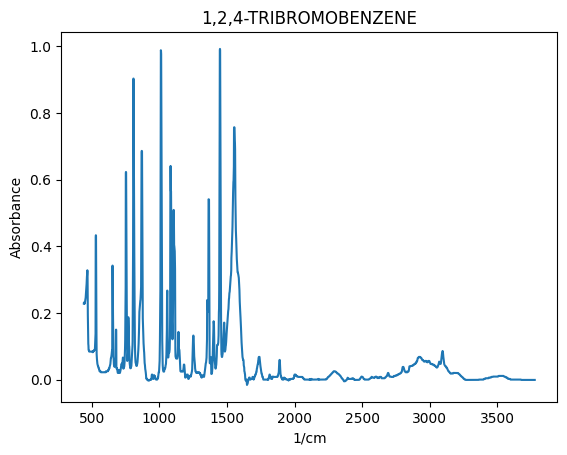

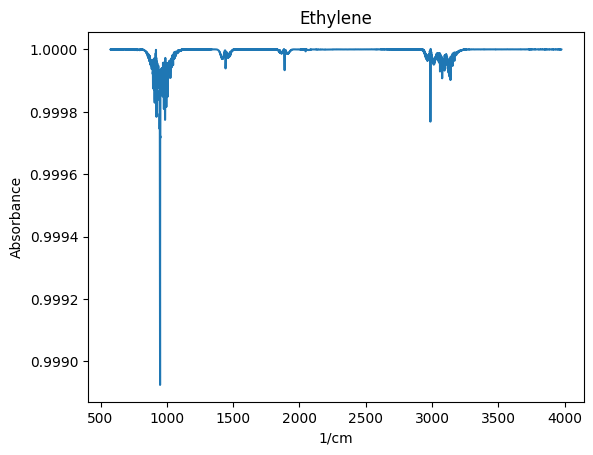

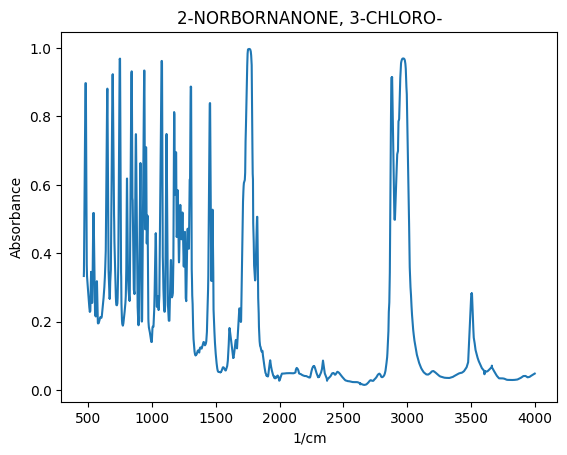

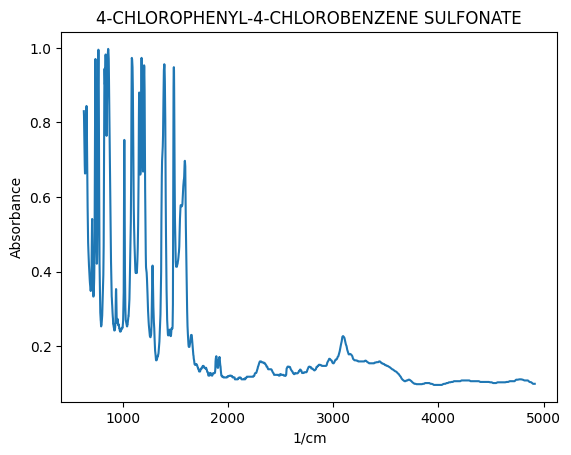

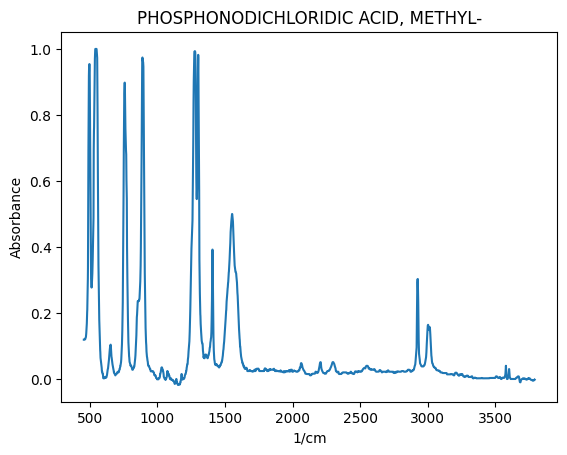

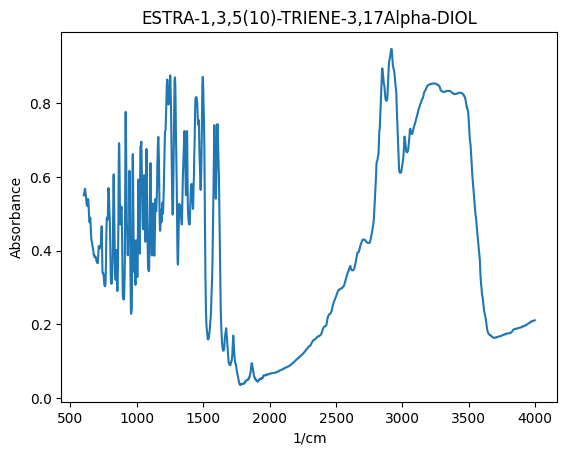

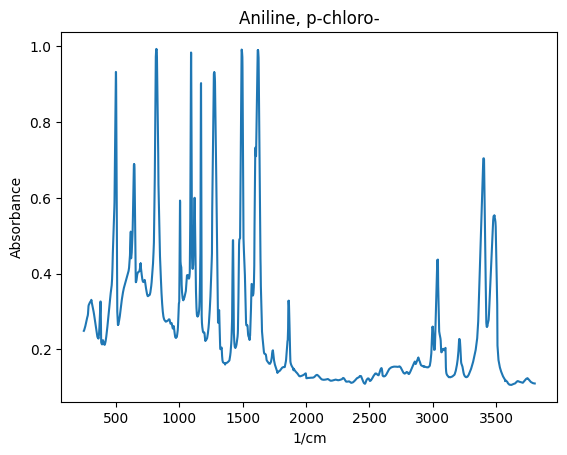

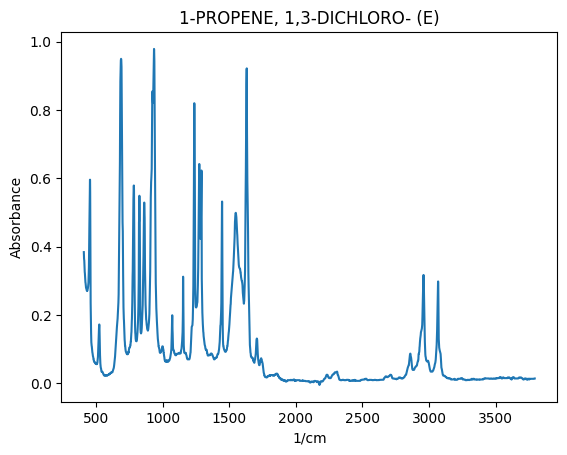

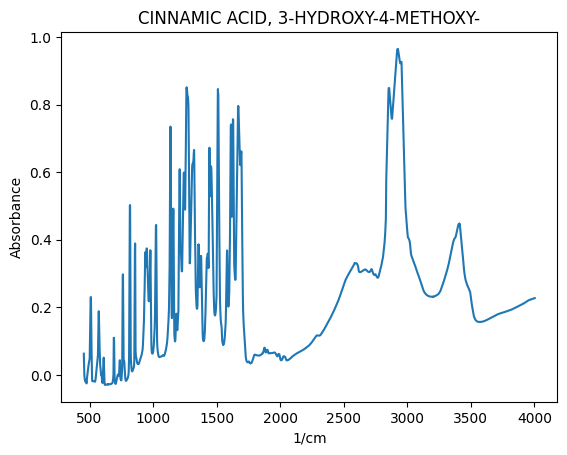

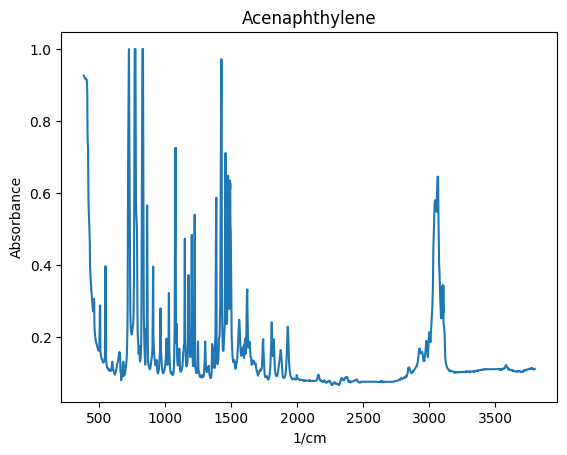

In [ ]:
# Try to read the file. If can't be read, skip it.
for i, file in enumerate(files[:10]):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        ref_spectra.append(sample)
        
        #print(ref_spectra[i])
        #print(ref_spectra[i]['x'])
        #print(ref_spectra[i]['y'])
        
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if ref_spectra[i]['yunits'] == "ABSORBANCE":
            pass 

        elif ref_spectra[i]['yunits'] == "TRANSMISSION" or "TRANSMITTANCE":
            
            ref_spectra[i]['y'] = 1 - ref_spectra[i]['y']
            #normalize
            #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # check xunits: if in microns, change to 1/cm
        if ref_spectra[i]['xunits'] == "MICROMETERS":
            ref_spectra[i]['x'] = 10000 / ref_spectra[i]['x']

        # uniformize data, #2:
        # normalize absorbance peaks (y-values) to between 0 and 1.
        #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
       
        

        # Nan check
        if np.isnan(ref_spectra[i]['y']).any(): print("Reading jcamp problem! Nan observed in Y")
        
        # plot data to allow visual inspections
        plt.plot(ref_spectra[i]['x'], ref_spectra[i]['y'])
        plt.title(ref_spectra[i]["title"])
        plt.xlabel('1/cm')
        plt.ylabel('Absorbance')
        plt.show()

    except:
        # print("File can't be read, please check:", files)
         continue

## Task 2: Дополнение списка ключами InChi/SMILES  

In [ ]:
# from urllib.request import urlopen

# #Функция для конвертации онлайн CAS номера в SMILES или Standart InChi описание молекулы

# def CasToInChiconvert(cas):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/stdinchi'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return cas

# def CasToSMILESconvert(cas):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/smiles'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return cas

# casno = ['50-78-2', '69-72-7', '95-1E-6', '108-24-7', '31710-30-2']

# for casid in casno:
#     print(CasToSMILESconvert(casid))

In [ ]:
!pip install cirpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cirpy
def cirpy_cas_to_smiles(cas):
  return cirpy.resolve(cas, 'smiles')
def cirpy_cas_to_inchi(cas):
  return cirpy.resolve(cas, 'inchi')

Добавим в таблицу к имеющимся CAS ключи SMILES и InChi. Занимает порядка 20 минут. Поэтому сохранено и загружено на ГитХаб. В дальнейшем импортируется из гита. А код убран под комментарий.

In [ ]:
# from tqdm import tqdm
# smiles_list = []
# inchi_list = []

# for casno in tqdm(nist_ir_spectra_list["CAS"]):
#   smile = cirpy_cas_to_smiles(casno)
#   smiles_list.append(smile)
#   inchi_list.append(cirpy_cas_to_inchi(casno))
 
# nist_ir_spectra_list["InChi"] = inchi_list
# nist_ir_spectra_list["SMILES"] = smiles_list

# nist_ir_spectra_list

In [ ]:
# nist_ir_spectra_list.to_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")

In [ ]:
nist_ir_spectra_list = pd.read_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")
#nist_ir_spectra_list=nist_ir_spectra_list.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
nist_ir_spectra_list = nist_ir_spectra_list.dropna()
nist_ir_spectra_list

,Unnamed: 0,CAS,Name,Formula,Mw,Elements,InChi,SMILES
0,0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1
1,1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O
2,2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O
3,5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C
4,6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl
...,...,...,...,...,...,...,...,...
14661,44445,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1
14662,44446,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C
14664,44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl
14666,44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O


## Task 3. Формирование списка типов связей в соединении

### Создаем список связей с вики

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def create_all_bonds_types_table():
  # Request information from wikipedia
  res = requests.get(
        "https://en.wikipedia.org/wiki/Infrared_spectroscopy_correlation_table")

  # Create a BeautifulSoup class
  soup = BeautifulSoup(res.content, 'lxml')

  # Extract info. from a table
  table = soup.find_all(class_="wikitable")[0]

  # Load table info. into a Pandas DataFrame
  df = pd.read_html(str(table), header=0)[0]
  return df

In [ ]:
all_bonds_types_table = create_all_bonds_types_table()
all_bonds_types_table

,Bond,Type of bond,Specific type of bond,Absorption peak (cm−1),Appearance
0,C─H,alkyl,methyl,1260,strong
1,C─H,alkyl,methyl,1380,weak
2,C─H,alkyl,methyl,2870,medium to strong
3,C─H,alkyl,methyl,2960,medium to strong
4,C─H,alkyl,methylene,1470,strong
...,...,...,...,...,...
87,N─O,nitro compounds,aromatic,1520,lower if conjugated
88,N─O,nitro compounds,aromatic,1350,lower if conjugated
89,P─C,Organophosphorus compound,aromatic,1440-1460,medium
90,P─O,phosphorus oxide,bonded,1195-1250,strong


Генерируем для каждого соединения набор связей по CAS номеру.

## Task 4. Создание списка классов по функциональным группам

### Типы и виды связей

In [ ]:
!pip install datamol
!pip install rdkit
clear_output()

In [ ]:
import datamol as dm

#Функция для генерации по smile набора связей

def create_bonds_table_from_mol(smile):
  if smile =='np.nan': print("There is no SMILE")
  else:
    list_of_bonds = []
    try:
      mol = dm.to_mol(smile)
      bonds = mol.GetBonds()
      
      for bond in bonds:
        begin_atom = bond.GetBeginAtom().GetSymbol()
        end_atom = bond.GetEndAtom().GetSymbol()
        bond_type = bond.GetBondType()
        if end_atom == "C": begin_atom, end_atom = end_atom, begin_atom
        list_of_bonds.append(f'{begin_atom} - {end_atom} {bond_type}')
    except AttributeError:
      list_of_bonds.append(np.nan)
      #print(f"Erorr with SMILE: {smileno} is not SMILE")
    except ValueError:
      list_of_bonds.append(np.nan)
    
    
    return list(set(list_of_bonds))


In [ ]:
from tqdm import tqdm
bond_list = []
for smileno in tqdm(nist_ir_spectra_list["SMILES"]):
    #print(smileno)
    bond_list.append(create_bonds_table_from_mol(smileno))
#print(bond_list)   
nist_ir_spectra_list['Bonds list'] = bond_list
nist_ir_spectra_list

  0%|          | 0/12233 [00:00<?, ?it/s][08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] Explicit valence for atom # 1 O, 4, is greater than permitted
[08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] WARNING: not removing hydrogen atom without neighbors
  1%|          | 134/12233 [00:00<00:09, 1330.95it/s][08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] WARNING: not removing hydrogen atom without neighbors
[08:53:59] WARNING: not removing hydrogen atom without neighbors
  4%|▎         | 448/12233 [00:00<00:07, 1516.84it/s][08:53:59] SMILES Parse Error: syntax error while parsing: [Cl]|[Sn](C)(C)C
[08:53:59] SMILES Parse Error: Failed parsing SMILES '[Cl]|[Sn](C)(C)C' for input: '[Cl]|[Sn](C)(C)C'
[08:53:59] SMILES Parse Error: syntax error while parsing: [Cl]|[Pb](CC)(CC)CC
[08

,Unnamed: 0,CAS,Name,Formula,Mw,Elements,InChi,SMILES,Bonds list
0,0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,"[N - O DOUBLE, C - C AROMATIC, O - N SINGLE, C..."
1,1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,"[C - N SINGLE, N - O SINGLE, C - C AROMATIC, N..."
2,2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,"[N - O DOUBLE, C - C AROMATIC, C - N SINGLE, N..."
3,5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,"[C - Si SINGLE, C - C SINGLE]"
4,6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,"[C - Si SINGLE, Si - Cl SINGLE, C - C SINGLE]"
...,...,...,...,...,...,...,...,...,...
14661,44445,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,"[C - N SINGLE, C - C AROMATIC, C - C SINGLE]"
14662,44446,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,"[C - C TRIPLE, C - C SINGLE]"
14664,44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,"[C - N SINGLE, C - Cl SINGLE, C - C SINGLE]"
14666,44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O,"[N - O DOUBLE, C - C AROMATIC, C - N SINGLE, N..."


### Функциональные группы

In [ ]:
#Функция для генерации бинарных меток присутствия функциональных групп 
#From https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning
import os
import logging
import argparse
import sys
import datamol as dm
import pandas as pd 
import numpy as np

from rdkit import Chem, RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

#from model.utils import set_logger
print('imports loaded')
func_grp_smarts = {'alkane':'[CX4;H0,H1,H2,H4]',
                   'methyl':'[CH3]',
                   'alkene':'[CX3]=[CX3]',
                   'alkyne':'[CX2]#C',
                   'alcohols':'[#6][OX2H]',
                   'amines':'[NX3;H2,H1;!$(NC=O)]',
                   'nitriles':'[NX1]#[CX2]', 
                   'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
                   'alkyl halides':'[#6][F,Cl,Br,I]', 
                   'esters':'[#6][CX3](=O)[OX2H0][#6]',
                   'ketones':'[#6][CX3](=O)[#6]',
                   'aldehydes':'[CX3H1](=O)[#6]', 
                   'carboxylic acids':'[CX3](=O)[OX2H1]',
                   'ether': '[OD2]([#6])[#6]',
                   'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
                   'amides':'[NX3][CX3](=[OX1])[#6]',
                   'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'}

bonds_smarts = {'alkane':'[CX4;H0,H1,H2,H4]',
                   'methyl':'[CH3]',
                   'alkene':'[CX3]=[CX3]',
                   'alkyne':'[CX2]#C',
                   'alcohols':'[#6][OX2H]',
                   'amines':'[NX3;H2,H1;!$(NC=O)]',
                   'nitriles':'[NX1]#[CX2]', 
                   'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
                   'alkyl halides':'[#6][F,Cl,Br,I]', 
                   'esters':'[#6][CX3](=O)[OX2H0][#6]',
                   'ketones':'[#6][CX3](=O)[#6]',
                   'aldehydes':'[CX3H1](=O)[#6]', 
                   'carboxylic acids':'[CX3](=O)[OX2H1]',
                   'ether': '[OD2]([#6])[#6]',
                   'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
                   'amides':'[NX3][CX3](=[OX1])[#6]',
                   'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]',
                'methylene':'[CH2]',
                'methine':"[CH]",
                'vinyl':'[]'
                }

def identify_functional_groups(inchi):
    '''Identify the presence of functional groups present in molecule 
       denoted by inchi

    Returns:
        mol_func_groups: (list) contains binary values of functional groups presence
                          None if inchi to molecule conversion returns warning or error
    '''
    
    try:
        #Convert inchi to molecule
        mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)   
        mol_func_grps = []
        #mol1 = dm.to_mol(inchi, sanitize=True)
        #dm.viz.to_image(mol1)
        #populate the list with group values
        for _, func_struct in func_grp_structs.items():
            
            #print(func_struct)
            dm.viz.to_image(func_struct)
            struct_matches = mol.GetSubstructMatches(func_struct)
            #print(struct_matches)
            contains_func_grp = int(len(struct_matches)>0)
            #print(contains_func_grp)
            mol_func_grps.append(contains_func_grp)
        return mol_func_grps
    except:

        return None

def save_target_to_csv(cas_inchi_df, save_path):
    '''Save the target dataframe as csv to path

    Args:
        cas_inchi_df: (pd.DataFrame) contains CAS and Inchi of molecules
        save_path: (string) path to store csv file

    Returns:
        None
    '''
    column_names = list(func_grp_structs.keys())    
    target_df = pd.DataFrame(index = cas_inchi_df.index, columns = column_names)

    #Iterate the rows, don't use df.apply since a list is being returned.
    for ind, (_, row) in enumerate(cas_inchi_df.iterrows()):
        target_df.iloc[ind, :] = identify_functional_groups(row['inchi'])
    

    target_df.dropna(inplace = True)
    target_df.to_csv(save_path)
    return target_df


imports loaded


In [ ]:
    # #Parsing the data from jdx and storing it in csv

    # func_grp_structs = {func_name : Chem.MolFromSmarts(func_smarts)\
    #                     for func_name, func_smarts in func_grp_smarts.items()}
    # print('funcgrpstruct')
    # #print(func_grp_structs)
    
    
    # logging.info('Loading inchi file from /content/IR_expert_system/data/nist_ir_spectra_list.csv')
    # inchi_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list.csv', header = 0, usecols = [1,6],\
    #                     names = ['CAS','inchi'], dtype = str)
    # #print(inchi_df)
    
    # inchi_df.dropna(inplace = True)
    # inchi_df.set_index('CAS', inplace = True)
    
    # # Create and save csv of target 
    # target_path = os.path.join('/content/IR_expert_system/data', 'target.csv')
    
    # save_target_to_csv(inchi_df, target_path)
    # target = pd.read_csv("/content/IR_expert_system/data/target.csv")
    # target

In [ ]:
# nist_ir_spectra_list_with_group = nist_ir_spectra_list.set_index('CAS').join(target.set_index('CAS'))
# nist_ir_spectra_list_with_group

In [ ]:
# nist_ir_spectra_list_with_group.to_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')

## Task 5. Визуализация данных.
Таблица данных о скачанных спектрах сформирована. Ключи и метки классов присвоены и сведены в таблицу. Требуется понять статитстику по спектрам.

In [ ]:
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
nist_ir_spectra_list_with_group

,CAS,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12228,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12229,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12230,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12231,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe()

,alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
count,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.00000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000
mean,0.679565,0.618701,0.134162,0.019061,0.222186,0.129990,0.03804,0.585733,0.260062,0.117147,0.092850,0.020370,0.061355,0.250900,0.009735,0.070517,0.057428
std,0.466663,0.485726,0.340841,0.136745,0.415732,0.336306,0.19130,0.492615,0.438686,0.321608,0.290234,0.141267,0.239990,0.433549,0.098188,0.256027,0.232668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
mean_of_groups = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().drop(['count', 'std', 'min', '25%', '50%', '75%', 'max'])
mean_of_groups = mean_of_groups.values.tolist()
print(mean_of_groups)

[[0.6795647905759162, 0.6187009162303665, 0.13416230366492146, 0.019060863874345548, 0.22218586387434555, 0.1299901832460733, 0.03803992146596859, 0.5857329842931938, 0.2600621727748691, 0.11714659685863875, 0.09285013089005235, 0.02036976439790576, 0.061354712041884814, 0.25089986910994766, 0.009734947643979058, 0.07051701570680628, 0.05742801047120419]]


In [ ]:
groups_names = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().columns.values
print(groups_names)

['alkane' 'methyl' 'alkene' 'alkyne' 'alcohols' 'amines' 'nitriles'
 'aromatics' 'alkyl halides' 'esters' 'ketones' 'aldehydes'
 'carboxylic acids' 'ether' 'acyl halides' 'amides' 'nitro']


<BarContainer object of 17 artists>

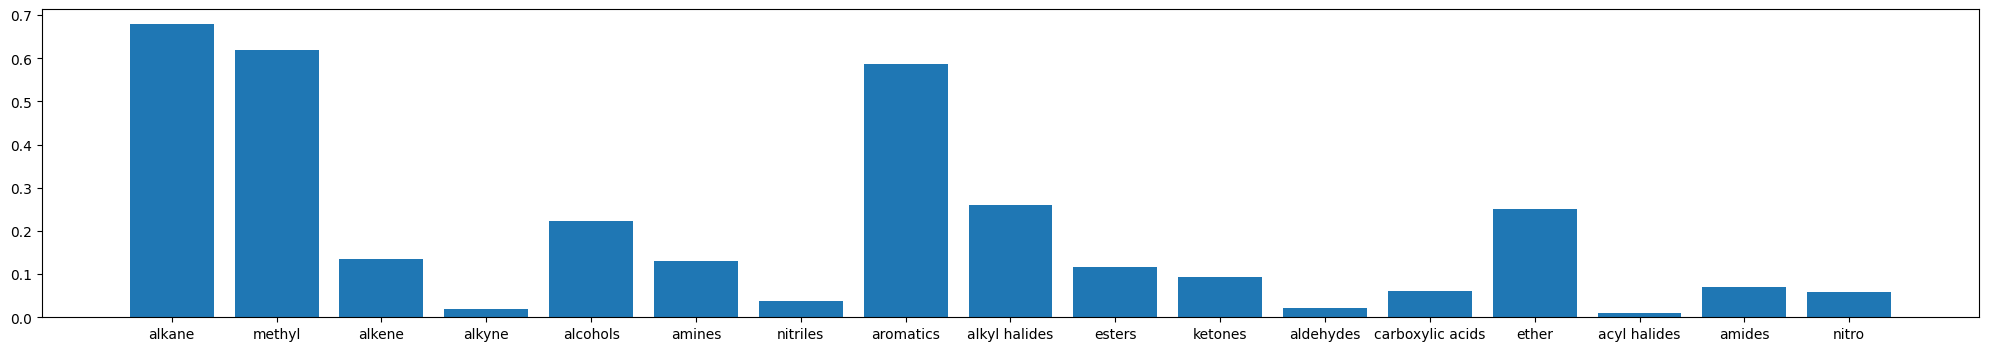

In [ ]:
plt.figure(figsize = (25,4))
plt.bar(groups_names, mean_of_groups[0])

Наблюдается сильный дисбаланс классов, что требует применения кроме бинарной кросс-энтропии для мультиклассовой модели, еще и правильного формирования батчей.

#Obj 4. Форматирование спектров в единый формат. Фильтрация неформатных спектров. 

## Task 1. Формирование статистики по диапазонам спектров.

In [ ]:
# Create an empty list to store spectra data
ref_spectra = []


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.

In [ ]:
from jcamp import jcamp_readfile
sample = jcamp_readfile(files[0])
#print(sample)
#print(sample["y"])
print(sample["cas registry no"])

615-54-3


Приведение спектров к одному формату по осям. Переназначение клеток таблицы, если формат оси был другой. Расчёт шага спектра в случае отсутствия оного.

In [ ]:
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])    
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass 

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"
            
            #normalize
           
        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]: 
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)

File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/3871-23-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116295-53-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/99972-22-2
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/7631-86-9
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/6596-69-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116401-36-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116402-66-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/51892-04-7
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/2467-03-0
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/502-99-8
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/7398-82-5
Fil

In [ ]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
615-54-3,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.054759964, 0.04684099, 0.058848847, 0.06609...",450,3966,880
930-99-4,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002106, 0.0001456, 0.0001716, 0.0002418, 0...",550,3846,825
33901-44-9,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.004623, 0.003723, 0.003733, 0.003493, 0.003...",549.759,4000.7,1790
3397-62-4,"[649.9584, 650.2457, 650.53174, 650.81793, 651...","[0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.3...",649.958374,4916.420898,1977
74-85-1,"[454.005, 454.94366, 455.88235, 456.821, 457.7...","[-0.014000058, -0.014000058, -0.014000058, -0....",454.005,3795.69,3561
...,...,...,...,...,...
6340-79-0,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.01919, 0.01902, 0.01907, 0.01857, 0.01853, ...",549.759,4000.7,1790
103-60-6,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.04065232, 0.033513375, 0.007634704, 0.01060...",450,3966,880
10364-94-0,"[549.766, 551.695, 553.624, 555.553, 557.482, ...","[0.001108, 0.000815, 0.001101, 0.001443, 0.001...",549.766,4000.75,1790
629-17-4,"[549.863, 551.7923, 553.7216, 555.6509, 557.58...","[0.00041007, 0.00042691, 0.00042051, 0.0004924...",549.863,3999.53,1789


In [ ]:
dataset_df.npoints.mean()

1840.4304335703332

In [ ]:
dataset_df.minx.mean()

530.5655705087576

In [ ]:
dataset_df.maxx.mean()

4107.095647145035

По всем прочинанным спектрам среднее значение 1800 точек. А диапазон должен быть примерно 500-4100. Что соответствует шагу в 2 (1/см).


## Task 2. Формирование диапазонов в 500-4100 [1/см] с шагом 2 [1/cm].

### Паддинг недостающих частей спектра.

Вид спектра:

In [ ]:
x = dataset_df[['x']].iloc[1].tolist()
y = dataset_df[['y']].iloc[1].tolist()

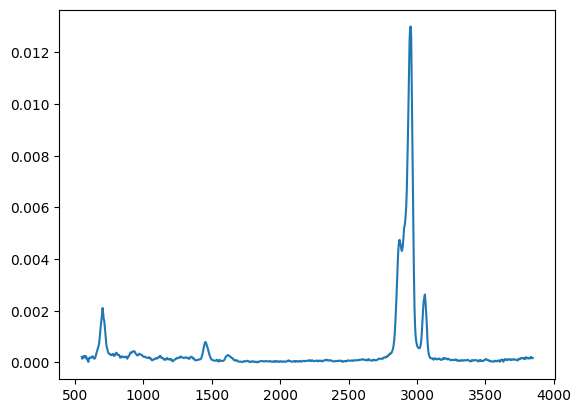

In [ ]:
plt.plot(x[0], y[0])

In [ ]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue 

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue 


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

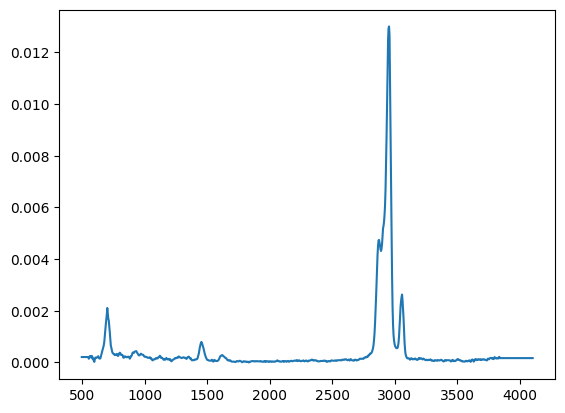

In [ ]:
x, y = padding_ir_below(x[0], y[0], 500.0)
x, y = padding_ir_above(x, y, 4100.0)
plt.plot(x, y)

###Функция для интерполирования:

In [ ]:
from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)
  
  return x_new, y_new



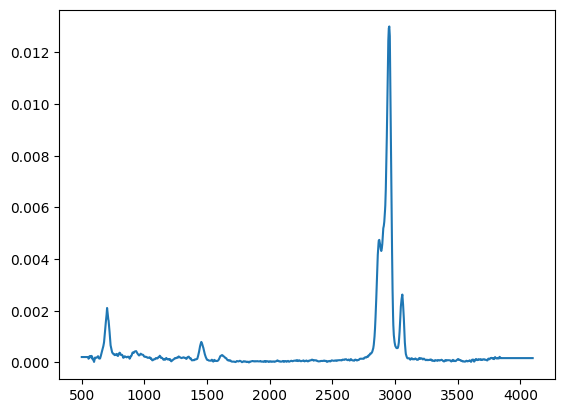

In [ ]:
x1, y1 = interpolate_in_borders_with_delta(x, y)
plt.plot(x1, y1)

In [ ]:
print(x1)
print(len(x1))
print(y1)
print(len(y1))

[ 500  502  504 ... 4094 4096 4098]
1800
[0.0002106 0.0002106 0.0002106 ... 0.000169  0.000169  0.000169 ]
1800


###Интерполирование всех спектров до одного размера и шага. 

In [ ]:
len(dataset_df[['x']])

14346

In [ ]:
x = dataset_df[['x']].iloc[1].to_numpy()
y = dataset_df[['y']].iloc[1].to_numpy()
x

array([array([ 550.,  554.,  558.,  562.,  566.,  570.,  574.,  578.,  582.,
               586.,  590.,  594.,  598.,  602.,  606.,  610.,  614.,  618.,
               622.,  626.,  630.,  634.,  638.,  642.,  646.,  650.,  654.,
               658.,  662.,  666.,  670.,  674.,  678.,  682.,  686.,  690.,
               694.,  698.,  702.,  706.,  710.,  714.,  718.,  722.,  726.,
               730.,  734.,  738.,  742.,  746.,  750.,  754.,  758.,  762.,
               766.,  770.,  774.,  778.,  782.,  786.,  790.,  794.,  798.,
               802.,  806.,  810.,  814.,  818.,  822.,  826.,  830.,  834.,
               838.,  842.,  846.,  850.,  854.,  858.,  862.,  866.,  870.,
               874.,  878.,  882.,  886.,  890.,  894.,  898.,  902.,  906.,
               910.,  914.,  918.,  922.,  926.,  930.,  934.,  938.,  942.,
               946.,  950.,  954.,  958.,  962.,  966.,  970.,  974.,  978.,
               982.,  986.,  990.,  994.,  998., 1002., 1006., 1010., 1014.,

In [ ]:
x_list, y_list = [], []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=errors
      x_list.append(np.nan)
      y_list.append(np.nan) 
print(f'Found {errors} errors')

100%|██████████| 14346/14346 [01:45<00:00, 135.85it/s]

Found 0 errors


In [ ]:
print(len(x_list))
print(len(y_list))
x_list

14346
14346


[array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 4094, 4096, 4098]),
 array([ 500,  502,  504, ..., 

In [ ]:
# for i in range(len(x_list)):
#   x_list[i]= x_list[i].astype(np.float32)
#   y_list[i]=y_list[i].astype(np.float32)

In [ ]:
x_arr = np.array(x_list)
y_arr = np.array(y_list)

<ipython-input-65-5b43c0e179b1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_arr = np.array(x_list)
<ipython-input-65-5b43c0e179b1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_arr = np.array(y_list)


In [ ]:
x_serie = pd.Series(x_arr)
print(len(x_serie[0]))
y_serie = pd.Series(y_arr)
print(type(x_serie))

1800
<class 'pandas.core.series.Series'>


In [ ]:
df_x = pd.DataFrame(x_serie, columns = ['x1'])
df_y = pd.DataFrame(y_serie, columns = ['y1'])
x, y = np.array(df_x.loc[10])[0], np.array(df_y.loc[10])[0]
print(y)

[0.01001543 0.00902707 0.00856583 ... 0.00388757 0.00388757 0.00388757]


# Нахождение пиков


In [ ]:
from scipy.signal import find_peaks

In [ ]:
# peak picking function

#I need to do a baseline subtraction and, perhaps, smoothing, using polyfit, so that the peak picking is the same throughout.

def pick_peaks(compound_name, x, y):
    from peakutils.peak import indexes as index_utils

    """ Identify peaks maxima. This algorithm is a 1-D search. It doesn't account for the x-values.
        ref.: #https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work
        
        Args:
        compound_name=to be used asa title in the generated plot (string).
        x=x-values (list)
        y=y-values (list)
        Returns:
        uses peakutils package to pick peaks in 1-D and plot out the x,y values, along with the identified peak maxima.
    """
    #rint(y[6])
    index_utils = index_utils(np.array(y), thres=0.05*max(y), min_dist=10, thres_abs = True)
    #index_utils = find_peaks(np.array(y), height=[0.01,0.9], threshold =0.0001, prominence=[0.0001, 50])
    #print(f'Peaks are:{index_utils[0]}')

    x_max = []
    y_max = []

    for each in index_utils:
        x_max.append(x[each])
        y_max.append(y[each])

    # plot the x,y pair of the identified maxima data points, i.e., indexes,
    # max_peaks:
    plt.plot(x, y, 'b-')
    plt.plot(x_max, y_max, 'rD', alpha=0.3)

    plt.title(compound_name)
    plt.ylabel("Absorbance")  # All units are transformed to absorbance
    plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm
    plt.show()

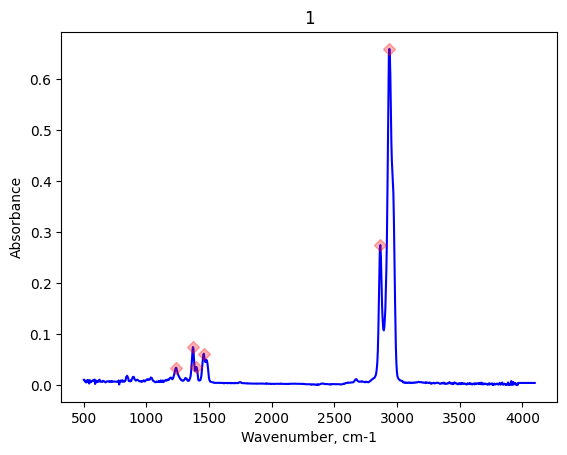

None


In [ ]:
from peakutils.peak import indexes as index_utils
pick = pick_peaks(1, x, y)
print(pick)

# Сохранение данных на диск